# AMLB shorter runs visualizations

In [1]:
import itertools
import math
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn

In [2]:
from data_processing import get_print_friendly_name, impute_missing_results, calculate_ranks, add_rescale, is_old
from visualization_early import FRAMEWORK_TO_COLOR

In [3]:
PROJECT_ROOT = Path(".").absolute().parent
DATA_DIRECTORY = PROJECT_ROOT / "data"
FIGURE_DIRECTORY = PROJECT_ROOT / "figures"

for subfolder in ["CD", "inference", "performance", "inference_by_time", "performance_by_time"]:
    (FIGURE_DIRECTORY / subfolder).mkdir(parents=True, exist_ok=True)

In [4]:
results = pd.read_csv(DATA_DIRECTORY / "amlb_all.csv", dtype={"info": str})

In [5]:
results_llm = pd.read_csv(DATA_DIRECTORY / "LLM_amlb_all.csv", dtype={"info": str})
results_llm['constraint'] = results_llm['constraint'].str.replace('8c_gp3', '')
results_llm['framework'] = results_llm['framework'] + '_' + results_llm['constraint']
results_llm['constraint'] = 'Mixed Time Constraints'
results = pd.concat([results, results_llm])
results["framework"] = results["framework"].apply(get_print_friendly_name)

In [6]:
# Assuming result is your DataFrame
filtered_df_naive = results[results['framework'].str.contains('NaiveAutoML_30min', na=False)]
unique_versions = filtered_df_naive['version'].unique()

print(unique_versions)

['0.1.2' 'master']


# Scaled Results

In [7]:
# Define a function to replace the prefix
def replace_prefix(framework, prefix):
    if framework.startswith(prefix):
        return framework[len(prefix):]
    return framework

In [8]:
def add_horizontal_lines(ax, lines: tuple[tuple[float, str], ...]):
    """Draws horizontal lines specified by (y value, color)-pairs."""
    for y, color in lines:
        ax.axhline(y, color=color)


def box_plot(data, metric=None, ylog=False, title="", ylim=None, figsize=(16, 9), with_framework_names=True, add_counts=None, color_map=None):
    """Creates a boxplot with data["frameworks"] on the x-axis and data[`metric`] on the y-axis
    
    The figure's y-axis may be limited by `ylim` and the number of values outside this limit may be shown in the tick labels.
    """
    if add_counts and (add_counts != "outliers" and not isinstance(add_counts, dict)):
        raise ValueError("`add_counts` must be 'outliers' or a dictionary mapping each framework to a number.")
        
    color_map = color_map or FRAMEWORK_TO_COLOR
    # color_map = {k: v for k, v in color_map.items() if k in data["framework"].unique() or k=="autosklearn2"}
    color_map = {k: v for k, v in color_map.items() if k in data["framework"].unique()}
   
    metric = metric or data.metric.unique()[0]
    if metric.startswith("neg_"):
        pos_metric = metric[len("neg_"):]
        data[pos_metric], metric = -data[metric], pos_metric

    # print(data.framework.unique())
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    seaborn.boxplot(
        data=data,
        x="framework",
        y=metric,
        order=color_map,
        hue="constraint" if data.constraint.nunique() > 1 else None,
        palette=color_map if data.constraint.nunique() == 1 else None,
        ax=ax,
        fliersize=1,
    )
    
    if ylog:
        ax.set_yscale("log")
        
    ax.set_ylabel(metric, size='xx-large')
    ax.set_xlabel("", fontsize=8)
    ax.tick_params(axis='both', which = 'both', labelsize = 18)
    
    if title:
        ax.set_title(title, fontsize=18)
        
    # Dirty hack for displaying outliers, we overlap minor and major tick labels, where
    # minor labels are used to display the number of outliers, and major tick labels may
    # be used to display the framework names.
    constraint = data.constraint.unique()[0]
    smetric = data.metric.unique()[0]
    frameworks = color_map.keys()
    print("frameworks", frameworks)
    if add_counts:
        # There will be minor tick labels displayed for outliers,
        # to avoid rendering on top of each other, we offset the label location
        # with a dirty hack of using leading spaces :-) 
        frameworks = [f"   {fw}" for fw in frameworks]
    ax.tick_params(axis="x", which="major", rotation=-90)
    ax.set_xticks(*zip(*enumerate(frameworks)))
    
    if ylim:  
        ax.set_ylim(ylim)
        if add_counts != "outliers":
            print("Warning! Ylim is set but outliers are not reported.")
    
    counts = []
    if add_counts:
        if add_counts == "outliers":
            add_counts = {}
            for framework in color_map:
                framework_outliers = data[(data["framework"] == framework) & (data[metric] < ylim[0])]
                add_counts[framework] = f"{len(framework_outliers)}"

        # We need to offset the minor tick labels, otherwise they won't render.
        ax.set_xticks(
            ticks=[i-0.01 for i in range(len(color_map))],
            labels=[f"[{add_counts.get(f, 'x')}]" for f in color_map], 
            minor=True
        )
        
    return fig, ax

In [9]:
strings_in_frameworks = ['AutoGluon(B)', 'AutoGluon(HQ)', 'AutoGluon(HQIL)', 'flaml', 'TPOT', 'lightautoml',
       'MLJAR(B)', 'GAMA(B)', 'H2OAutoML', 'NaiveAutoML', 'FEDOT', 'autosklearn', 'autosklearn2', 'GeneticLLM_AutoML'] # Add  'AutoGluon_FI_FT_IL' later for early stopping

In [10]:
name_mapping = {
    'constantpredictor_60min': 'CP_60min',
    'TunedRandomForest_60min': 'TRF_60min'
}

### All frameworks by time

In [11]:
strings_by_time = ['_5min',]
extra_frameworks = ['RF_60min', 'TRF_60min', 'CP_60min']

In [12]:
results.framework.unique()

array(['AutoGluon(HQIL)_10min', 'AutoGluon(HQIL)_30min',
       'AutoGluon(HQIL)_5min', 'AutoGluon(HQIL)_60min',
       'AutoGluon(HQ)_10min', 'AutoGluon(HQ)_30min', 'AutoGluon(HQ)_5min',
       'AutoGluon(HQ)_60min', 'AutoGluon(B)_10min', 'AutoGluon(B)_30min',
       'AutoGluon(B)_5min', 'AutoGluon(B)_60min', 'FEDOT_10min',
       'FEDOT_30min', 'FEDOT_5min', 'FEDOT_60min', 'GAMA(B)_10min',
       'GAMA(B)_30min', 'GAMA(B)_5min', 'GAMA(B)_60min',
       'H2OAutoML_10min', 'H2OAutoML_30min', 'H2OAutoML_5min',
       'H2OAutoML_60min', 'NaiveAutoML_10min', 'NaiveAutoML_30min',
       'NaiveAutoML_5min', 'NaiveAutoML_60min', 'RF_10min', 'RF_30min',
       'RF_5min', 'RF_60min', 'TPOT_10min', 'TPOT_30min', 'TPOT_5min',
       'TPOT_60min', 'TRF_10min', 'TRF_30min', 'TRF_5min', 'TRF_60min',
       'autosklearn2_10min', 'autosklearn2_30min', 'autosklearn2_5min',
       'autosklearn2_60min', 'autosklearn_10min', 'autosklearn_30min',
       'autosklearn_5min', 'autosklearn_60min', 'CP_10min',

C:\Users\20210595\AppData\Local\Temp\ipykernel_23372\245108612.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_framework['framework'] = this_framework['framework'].apply(lambda x: name_mapping.get(x, x))


generating box-rescaled_5min_cp.pdf
frameworks dict_keys(['CP', 'GeneticLLM'])


C:\Users\20210595\AppData\Local\Temp\ipykernel_23372\1221873700.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  seaborn.boxplot(


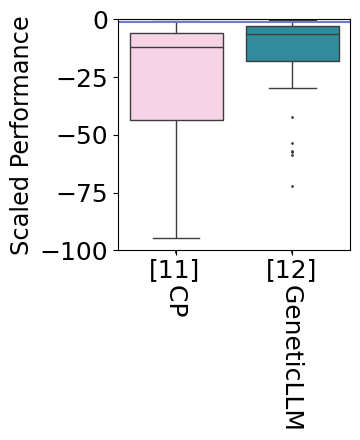

In [13]:
from matplotlib.backends.backend_pdf import PdfPages

for name_time in strings_by_time:
    this_framework = results[results['framework'].str.contains(name_time) | results['framework'].isin(extra_frameworks)]
    this_framework['framework'] = this_framework['framework'].apply(lambda x: name_mapping.get(x, x))
    data = this_framework
    data = impute_missing_results(data, with_results_from="CP_60min")

    exclude = ['CP_60min']
    data = data[~data["framework"].isin(exclude)]    

    data = data[["framework", "task", "constraint", "metric", "result"]].groupby(["framework", "task", "constraint", "metric"], as_index=False).mean()
    data = add_rescale(data, lower="RF_60min")
    data["scaled"] = -data["scaled"]
    data = data[data["framework"] != "RF_60min"]  # Not interesting as it is -1 by definition
    data['framework'] = data['framework'].str.replace(name_time, '')
    data['framework'] = data['framework'].str.replace('_60min', '') # This is for the baselines _60min

    # Filter the dataframe to keep only the specified frameworks
    data = data[data['framework'].isin(['CP', 'GeneticLLM'])]
    
    
    filename = f"box-rescaled{name_time}_cp.pdf".replace(" ", "-")
    print("generating", filename)
    
    periwinkle_blue = "#6f7cc8"
    fig, ax = box_plot(
        data,
        metric="scaled", 
        ylim=[-100, 0],
        figsize=(3, 3),
        add_counts="outliers"
    )
    ax.set_ylabel("Scaled Performance")
    add_horizontal_lines(ax, ((-1, periwinkle_blue),))
    
    plt.show()
    with PdfPages(FIGURE_DIRECTORY / "performance_by_time" / filename) as f:
        f.savefig(fig, bbox_inches="tight")

    # Define the file path for the PNG file
    file_path = FIGURE_DIRECTORY / "performance_by_time" / f"{filename.replace('pdf', 'png')}"
    # Save the figure as a PNG file
    fig.savefig(file_path, bbox_inches="tight", dpi=1000)


### type

Processing type: binary


C:\Users\20210595\AppData\Local\Temp\ipykernel_23372\2496205278.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_framework['framework'] = this_framework['framework'].apply(lambda x: name_mapping.get(x, x))


generating box-rescaled_binary__5min_cp.pdf
frameworks dict_keys(['CP', 'GeneticLLM'])


C:\Users\20210595\AppData\Local\Temp\ipykernel_23372\1221873700.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  seaborn.boxplot(


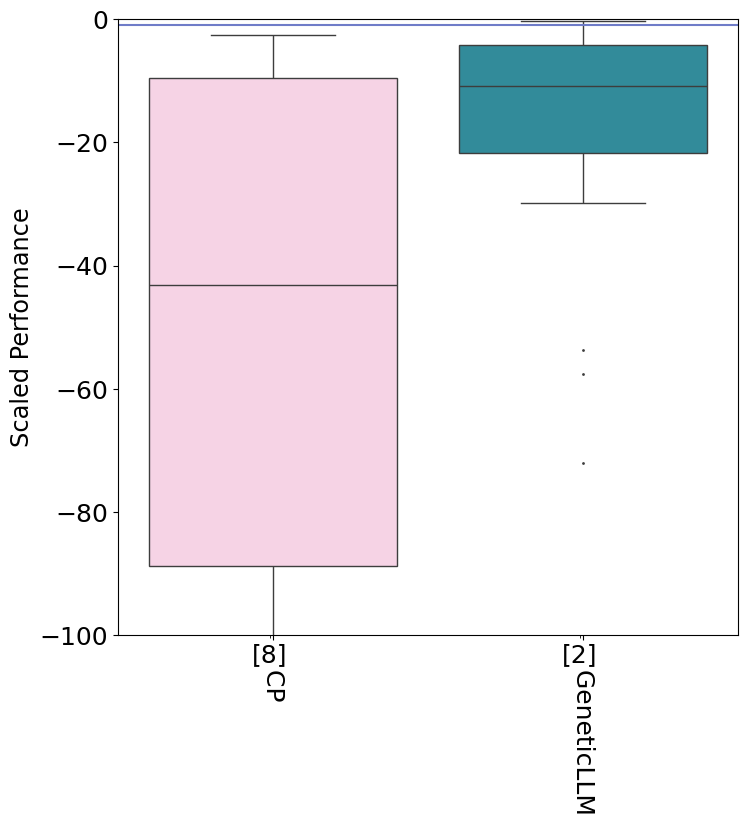

Processing type: multiclass


C:\Users\20210595\AppData\Local\Temp\ipykernel_23372\2496205278.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_framework['framework'] = this_framework['framework'].apply(lambda x: name_mapping.get(x, x))


generating box-rescaled_multiclass__5min_cp.pdf
frameworks dict_keys(['CP', 'GeneticLLM'])


C:\Users\20210595\AppData\Local\Temp\ipykernel_23372\1221873700.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  seaborn.boxplot(


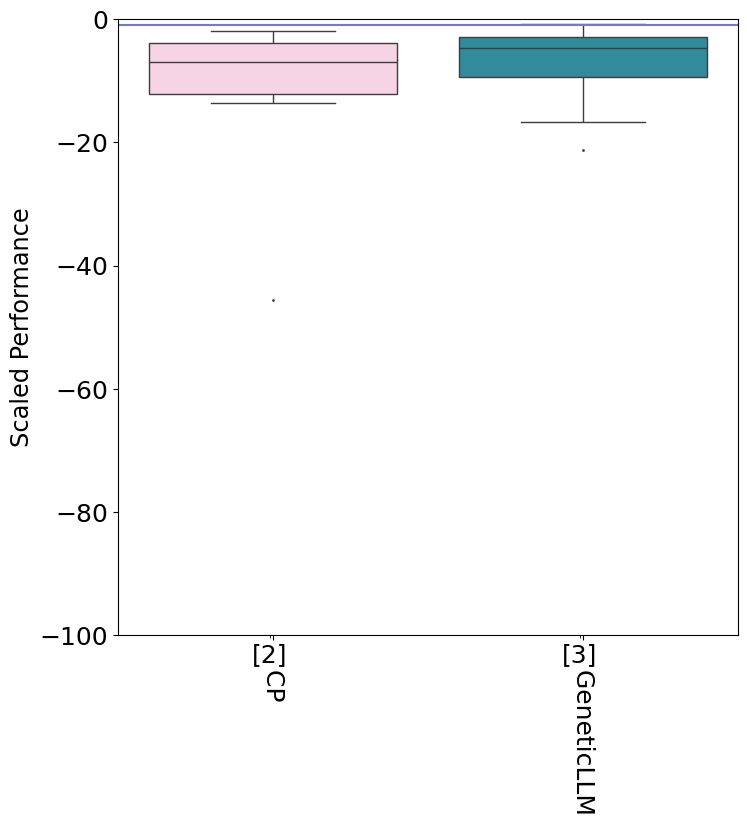

Processing type: regression


C:\Users\20210595\AppData\Local\Temp\ipykernel_23372\2496205278.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_framework['framework'] = this_framework['framework'].apply(lambda x: name_mapping.get(x, x))


generating box-rescaled_regression__5min_cp.pdf
frameworks dict_keys(['CP', 'GeneticLLM'])


C:\Users\20210595\AppData\Local\Temp\ipykernel_23372\1221873700.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  seaborn.boxplot(


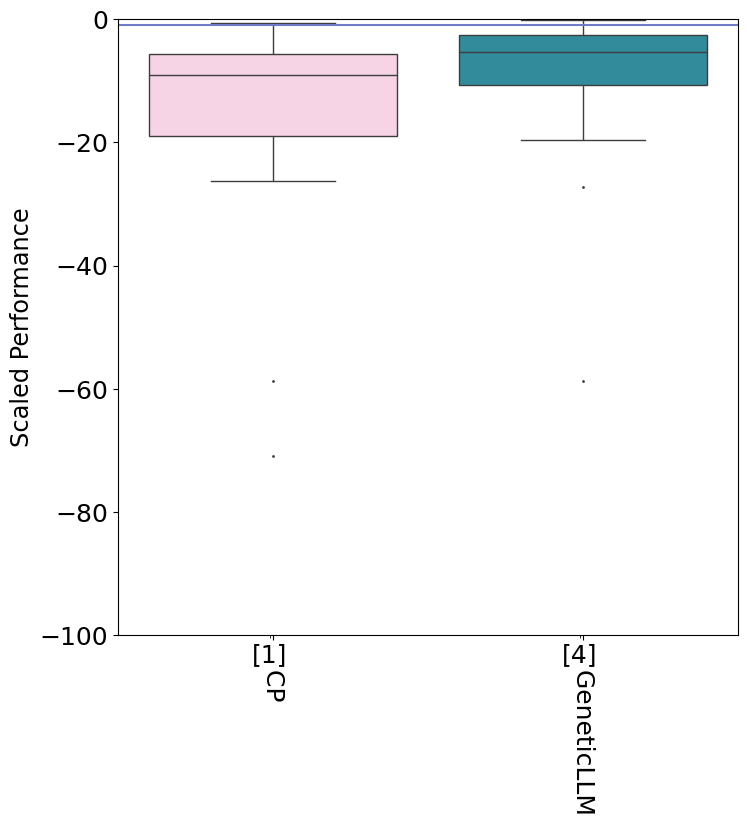

In [14]:


# Group the DataFrame by 'type'
grouped_by_type = results.groupby('type')

# Iterate over each group
for type_name, group in grouped_by_type:
    print(f"Processing type: {type_name}")
    
    for name_time in strings_by_time:
        this_framework = group[group['framework'].str.contains(name_time) | group['framework'].isin(extra_frameworks)]
        this_framework['framework'] = this_framework['framework'].apply(lambda x: name_mapping.get(x, x))
        data = this_framework
        data = impute_missing_results(data, with_results_from="CP_60min")

        exclude = ['CP_60min']
        data = data[~data["framework"].isin(exclude)]    

        data = data[["framework", "task", "constraint", "metric", "result"]].groupby(["framework", "task", "constraint", "metric"], as_index=False).mean()
        data = add_rescale(data, lower="RF_60min")
        data["scaled"] = -data["scaled"]
        data = data[data["framework"] != "RF_60min"]  # Not interesting as it is -1 by definition
        data['framework'] = data['framework'].str.replace(name_time, '')
        data['framework'] = data['framework'].str.replace('_60min', '')  # This is for the baselines _60min

        # Filter the dataframe to keep only the specified frameworks
        data = data[data['framework'].isin(['CP', 'GeneticLLM'])]

        filename = f"box-rescaled_{type_name}_{name_time}_cp.pdf".replace(" ", "-")
        print("generating", filename)
        
        periwinkle_blue = "#6f7cc8"
        fig, ax = box_plot(
            data,
            metric="scaled", 
            ylim=[-100, 0],
            figsize=(8, 8),
            add_counts="outliers"
        )
        ax.set_ylabel("Scaled Performance")
        add_horizontal_lines(ax, ((-1, periwinkle_blue),))
        
        plt.show()
        with PdfPages(FIGURE_DIRECTORY / "performance_by_time" / filename) as f:
            f.savefig(fig, bbox_inches="tight")

        # Define the file path for the PNG file
        file_path = FIGURE_DIRECTORY / "performance_by_time" / f"{filename.replace('pdf', 'png')}"
        # Save the figure as a PNG file
        fig.savefig(file_path, bbox_inches="tight", dpi=1000)

In [15]:
# Concatenate data for all types
all_data = []

# Group the DataFrame by 'type'
grouped_by_type = results.groupby('type')

# Iterate over each group
for type_name, group in grouped_by_type:
    print(f"Processing type: {type_name}")
    
    for name_time in strings_by_time:
        this_framework = group[group['framework'].str.contains(name_time) | group['framework'].isin(extra_frameworks)]
        this_framework['framework'] = this_framework['framework'].apply(lambda x: name_mapping.get(x, x))
        data = this_framework
        data = impute_missing_results(data, with_results_from="CP_60min")

        exclude = ['CP_60min']
        data = data[~data["framework"].isin(exclude)]    

        data = data[["framework", "task", "constraint", "metric", "result"]].groupby(["framework", "task", "constraint", "metric"], as_index=False).mean()
        data = add_rescale(data, lower="RF_60min")
        data["scaled"] = -data["scaled"]
        data = data[data["framework"] != "RF_60min"]  # Not interesting as it is -1 by definition
        data['framework'] = data['framework'].str.replace(name_time, '')
        data['framework'] = data['framework'].str.replace('_60min', '')  # This is for the baselines _60min

        # Filter the dataframe to keep only the specified frameworks
        data = data[data['framework'].isin(['CP', 'GeneticLLM'])]

        # Add type information to the data
        data['type'] = type_name

        # Append the data to the list
        all_data.append(data)



Processing type: binary


C:\Users\20210595\AppData\Local\Temp\ipykernel_23372\216454249.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_framework['framework'] = this_framework['framework'].apply(lambda x: name_mapping.get(x, x))


Processing type: multiclass


C:\Users\20210595\AppData\Local\Temp\ipykernel_23372\216454249.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_framework['framework'] = this_framework['framework'].apply(lambda x: name_mapping.get(x, x))


Processing type: regression


In [16]:
# Concatenate all data into a single DataFrame
all_data_df = pd.concat(all_data)
def add_short_framework_type(row):
    if row['type'] == 'regression':
        return row['framework'] + '_r'
    elif row['type'] == 'binary':
        return row['framework'] + '_b'
    elif row['type'] == 'multiclass':
        return row['framework'] + '_m'
    else:
        return row['type']

# Apply the function to the DataFrame
all_data_df['framework_type'] = all_data_df.apply(add_short_framework_type, axis=1)

# Print the modified DataFrame
all_data_df

,framework,task,constraint,metric,result,scaled,rescaled,type,framework_type
123,CP,APSFailure,Mixed Time Constraints,auc,0.500000,-185.511002,NaN,binary,CP_b
124,CP,Australian,Mixed Time Constraints,auc,0.500000,-67.832037,NaN,binary,CP_b
125,CP,Bioresponse,Mixed Time Constraints,auc,0.500000,-94.891163,NaN,binary,CP_b
126,CP,Click_prediction_small,Mixed Time Constraints,auc,0.500000,-5.543642,NaN,binary,CP_b
127,CP,Internet-Advertisements,Mixed Time Constraints,auc,0.500000,-287.164753,NaN,binary,CP_b
...,...,...,...,...,...,...,...,...,...
226,GeneticLLM,tecator,Mixed Time Constraints,neg_rmse,-0.851853,-0.280201,NaN,regression,GeneticLLM_r
227,GeneticLLM,topo_2_1,Mixed Time Constraints,neg_rmse,-0.029439,-3.818946,NaN,regression,GeneticLLM_r
228,GeneticLLM,us_crime,Mixed Time Constraints,neg_rmse,-0.164462,-5.404251,NaN,regression,GeneticLLM_r
229,GeneticLLM,wine_quality,Mixed Time Constraints,neg_rmse,-0.724005,-8.981093,NaN,regression,GeneticLLM_r


C:\Users\20210595\AppData\Local\Temp\ipykernel_23372\2533005464.py:8: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:red'` for the same effect.

  seaborn.stripplot(data=all_data_df, x="framework", y="scaled", hue="type",


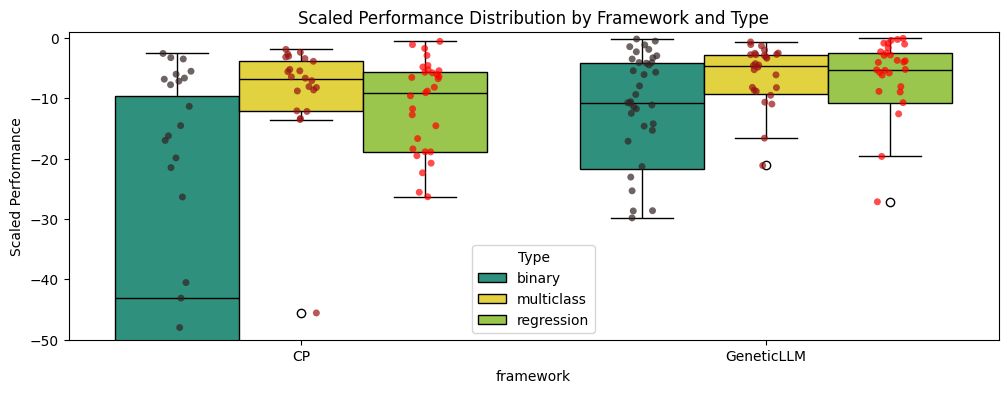

In [17]:
all_data_df = all_data_df.reset_index(drop=True)

# Create the boxplot
plt.figure(figsize=(12, 4))
seaborn.boxplot(data=all_data_df, x="framework", y="scaled", hue="type", palette=FRAMEWORK_TO_COLOR)

# Overlay the stripplot to show individual data points
seaborn.stripplot(data=all_data_df, x="framework", y="scaled", hue="type", 
              dodge=True, jitter=True, color='red', alpha=0.7)

plt.ylim(-50, 1)
plt.ylabel("Scaled Performance")
plt.title("Scaled Performance Distribution by Framework and Type")
plt.legend(title='Type')


# Remove duplicate legend entries, keeping the first occurrence
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = []
unique_handles = []
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handle)

plt.legend(unique_handles, unique_labels, title='Type')

plt.show()

C:\Users\20210595\AppData\Local\Temp\ipykernel_23372\544747866.py:15: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:red'` for the same effect.

  seaborn.stripplot(data=all_data_df, x="framework_type", y="scaled", hue="type",


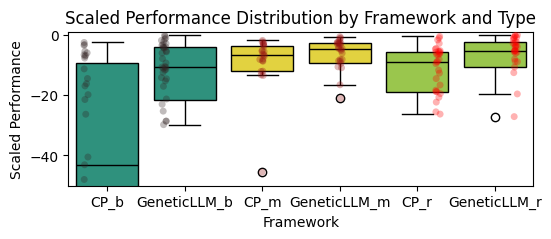

In [27]:
# Define the order of the categories
order = (
    all_data_df[all_data_df['type'] == 'binary']['framework_type'].unique().tolist() +
    all_data_df[all_data_df['type'] == 'multiclass']['framework_type'].unique().tolist() +
    all_data_df[all_data_df['type'] == 'regression']['framework_type'].unique().tolist()
)

all_data_df = all_data_df.reset_index(drop=True)

# Create the boxplot
plt.figure(figsize=(6, 2))
seaborn.boxplot(data=all_data_df, x="framework_type", y="scaled", hue="type", palette=FRAMEWORK_TO_COLOR, order=order)

# Overlay the stripplot to show individual data points
seaborn.stripplot(data=all_data_df, x="framework_type", y="scaled", hue="type", 
              dodge=True, jitter=True, color='red', alpha=0.3, order=order)

plt.ylim(-50, 1)
plt.ylabel("Scaled Performance")
plt.xlabel("Framework")
plt.title("Scaled Performance Distribution by Framework and Type")
plt.legend(title='Type')

# Remove duplicate legend entries, keeping the first occurrence
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = []
unique_handles = []
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handle)

# plt.legend(unique_handles, unique_labels, title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().legend_.remove()

# Save the figure
filename = "performance_cp_by_type.png"
plt.savefig(FIGURE_DIRECTORY / "performance_by_time" / filename, bbox_inches='tight', dpi=300)

plt.show()

C:\Users\20210595\AppData\Local\Temp\ipykernel_23372\838070974.py:16: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:red'` for the same effect.

  seaborn.stripplot(


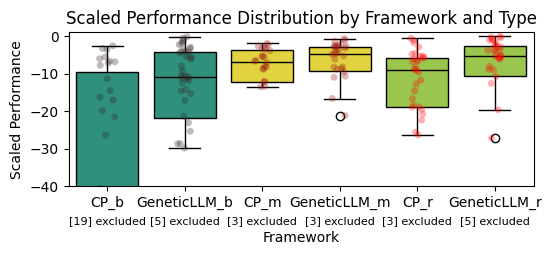

In [36]:
# Calculate the number of points outside the y-axis limits
y_min, y_max = -40, 1  # Defined y-axis limits
excluded_points = all_data_df.groupby('framework_type').apply(
    lambda group: ((group['scaled'] < y_min) | (group['scaled'] > y_max)).sum()
)

# Reset the index to align with the x-axis order
excluded_points = excluded_points.reindex(order)

# Plot the figure
plt.figure(figsize=(6, 2))
seaborn.boxplot(data=all_data_df, x="framework_type", y="scaled", hue="type", palette=FRAMEWORK_TO_COLOR, order=order)
#seaborn.stripplot(data=all_data_df, x="framework_type", y="scaled", hue="type", 
#                   dodge=True, jitter=True, color='red', alpha=0.3, order=order)

seaborn.stripplot(
    data=all_data_df, 
    x="framework_type", 
    y="scaled", 
    hue="type", 
    dodge=False,  # Ensure points are centered
    jitter=True, 
    color='red', 
    alpha=0.3, 
    order=order
)

# Annotate the number of excluded points below each category
for i, (framework, count) in enumerate(excluded_points.items()):
    if count > 0:
        plt.text(
            x=i, y=y_min - 8, s=f"[{count}] excluded", 
            ha='center', va='top', fontsize=8, color='black'
        )

plt.ylim(y_min, y_max)
plt.ylabel("Scaled Performance")
plt.xlabel("Framework", labelpad=15)  # Adjusted label position
plt.title("Scaled Performance Distribution by Framework and Type")
plt.legend(title='Type')

# Remove duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = []
unique_handles = []
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handle)

plt.gca().legend_.remove()

# Save the figure
filename = "performance_cp_by_type_with_excluded.png"
plt.savefig(FIGURE_DIRECTORY / "performance_by_time" / filename, bbox_inches='tight', dpi=300)

plt.show()
